
<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./Kregime_Propagating_jupyter.ipynb" download="Kregime_Propagating_jupyter.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=Kregime_Propagating_jupyter.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/PhaseField/Kregime_Propagating_jupyter_notebook/Kregime_Propagating_jupyter.py"><img src="https://img.shields.io/static/v1?label=Source:&message=Kregime_Propagating_jupyter.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/master?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/PhaseField/Kregime_Propagating_jupyter_notebook/Kregime_Propagating_jupyter.py%26branch=master%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>

## Hydraulic Fracturing in the Toughness-Dominated Regime


Under the toughness-dominated regime without leak-off, the fluid viscosity dissipation is negligible compared to the energy released for fracture surface formation (**Detournay _et al._, 2016**). Therefore, in this regime, we can neglect the pressure loss within the fracture and use the Sneddon solution for crack opening (**Bourdin _et al._, 2012**, **Sneddon et al., 1969**) to determine the pressure and length evolution.

The work of the pressure force is as follows:

$$
\begin{equation}
\mathcal{W}(R) =\frac{2 p^2 a^2}{E'}.
\end{equation}
$$

Applying Clapeyron's theorem, the elastic energy can be determined as

$$
\begin{equation}
\mathcal{E}(R) =-\frac{\pi p^2 a^2}{E'},
\end{equation}
$$
and the energy release rate with respect to the crack length $a$ propagating along the initial inclination is
$$
\begin{equation}
G(R) = - \frac{\partial \mathcal{E}}{\partial (2 a)} = \frac{\pi p^2 a}{E'}.
\end{equation}
$$

Griffith\'s criterion (**Griffith _et al._, 1920**) states that the fracture propagates when $G=G_c$ and the critical volume for crack propagation is $V_c := \sqrt{\dfrac{4 \pi G_c a^3}{E' }}$ in a quasi-static volume control setting (the fracture propagation is always unstable with pressure control).


The evolution of the corresponding pressure and fracture length
$$
\begin{equation}
p(V) =
\begin{cases}
\dfrac{E' V}{2 \pi a_0^2} &\text{for} V <  V_c \\
\left[  \dfrac{2 E' G_c^2}{\pi V} \right] ^{\frac{1}{3}}&\text{for}    V \geq V_c,
\end{cases}
\end{equation}
$$

$$
\begin{equation}
a(V) =
\begin{cases}
a_0 & V <  V_c \\
\left[ \dfrac{E' V^2}{4 \pi G_c} \right ] ^{\frac{1}{3}} &    V \geq V_c.
\end{cases}
\end{equation}
$$

# Problem Description

Based on Sneddon\'s solution (**Sneddon et al., 1969**), we verified the model with plane-strain hydraulic fracture propagation in a toughness-dominated regime. In an infinite 2D domain, the problem was solved with a line fracture $[-a_0, a_0] \times \{0\}$ ($a_0$ = 0.05). We considered a large finite domain $[-40a_0,40a_0] \times [-40a_0,40a_0]$ to account for the infinite boundaries in the closed-form solution. The effective size of an element, $h$, is $1\times10^{-2}$.

![Schematic view of hydraulic fracturing problem and Boundary conditions](./figures/Model_propagating_straight.png#one-half "Schematic view of hydraulic fracturing problem and Boundary conditions.")

* In order to  have the hydraulic fracturing in the toughness dominated-regime, add, $\texttt{<pressurized_crack_scheme>propagating</pressurized_crack_scheme>}$ in the project file.
* **Yoshioka _et al._, 2019**  provides additional information on the implementation, use of real material properties, and rescaling of the phase-field energy functional.


# Input Data

Taking advantage of the linearity of the system, the simulations were run with the dimensionless properties listed in the Table below.

| **Name**                       | **Value**         | **Symbol** |
|--------------------------------|------------------ |------------|
| _Young's modulus_              | 1                 | $E$        |
| _Poisson's ratio_              | 0.15              | $\nu$      |
| _Fracture toughness_           | 1                 | $G_{c}$    |
| _Regularization parameter_     | 2$h$              | $\ell_s$   |
| _Length_                       | 4                 | $L$        |
| _Height_                       | 4                 | $H$        |
| _Initial crack length_         | 0.1               | $2a_0$     |

In [1]:
import math
import os
import re
import time
from pathlib import Path
from subprocess import run

import gmsh
import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot
import pyvista as pv
from ogstools.msh2vtu import msh2vtu

In [2]:
pi = math.pi
plt.rcParams["text.usetex"] = True

In [3]:
E = 1.0
nu = 0.15
Gc = 1.0
h = 0.01
a0 = 0.05  # half of the initial crack length

phasefield_model = "AT1"  # AT1/AT2

# Output Directory  and Project File

In [4]:
# file's name
prj_name = "Kregime_Propagating.prj"
meshname = "mesh_full_pf"

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
if not out_dir.exists():
    out_dir.mkdir(parents=True)

# Mesh Generation


In [5]:
def mesh_generation(lc, lc_fine):
    """
    lc ... characteristic length for coarse meshing
    lc_fine ... characteristic length for fine meshing
    """
    L = 4.0  # Length
    H = 4.0  # Height
    b = 0.4  # Length/Height of subdomain with fine mesh

    # Before using any functions in the Python API, Gmsh must be initialized
    gmsh.initialize()
    gmsh.option.setNumber("General.Terminal", 1)
    gmsh.model.add("rectangle")

    # Dimensions
    dim0 = 0
    dim1 = 1
    dim2 = 2

    # Points
    gmsh.model.geo.addPoint(-L / 2, -H / 2, 0, lc, 1)
    gmsh.model.geo.addPoint(L / 2, -H / 2, 0, lc, 2)
    gmsh.model.geo.addPoint(L / 2, H / 2, 0, lc, 3)
    gmsh.model.geo.addPoint(-L / 2, H / 2, 0, lc, 4)
    gmsh.model.geo.addPoint(-b, -b - lc_fine / 2, 0, lc_fine, 5)
    gmsh.model.geo.addPoint(b, -b - lc_fine / 2, 0, lc_fine, 6)
    gmsh.model.geo.addPoint(b, b + lc_fine / 2, 0, lc_fine, 7)
    gmsh.model.geo.addPoint(-b, b + lc_fine / 2, 0, lc_fine, 8)

    # Lines
    gmsh.model.geo.addLine(1, 2, 1)
    gmsh.model.geo.addLine(2, 3, 2)
    gmsh.model.geo.addLine(3, 4, 3)
    gmsh.model.geo.addLine(4, 1, 4)
    gmsh.model.geo.addLine(5, 6, 5)
    gmsh.model.geo.addLine(6, 7, 6)
    gmsh.model.geo.addLine(7, 8, 7)
    gmsh.model.geo.addLine(8, 5, 8)

    # Line loops
    gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
    gmsh.model.geo.addCurveLoop([5, 6, 7, 8], 2)

    # Add plane surfaces defined by one or more curve loops.
    gmsh.model.geo.addPlaneSurface([1, 2], 1)
    gmsh.model.geo.addPlaneSurface([2], 2)

    gmsh.model.geo.synchronize()

    # Prepare structured grid
    gmsh.model.geo.mesh.setTransfiniteCurve(
        6, math.ceil(2 * b / lc_fine + 2), "Progression", 1
    )
    gmsh.model.geo.mesh.setTransfiniteCurve(
        8, math.ceil(2 * b / lc_fine + 2), "Progression", 1
    )
    gmsh.model.geo.mesh.setTransfiniteSurface(2, "Alternate")

    gmsh.model.geo.mesh.setRecombine(dim2, 1)
    gmsh.model.geo.mesh.setRecombine(dim2, 2)

    gmsh.model.geo.synchronize()

    # Physical groups
    P1 = gmsh.model.addPhysicalGroup(dim0, [1])
    gmsh.model.setPhysicalName(dim0, P1, "P1")

    P2 = gmsh.model.addPhysicalGroup(dim0, [2])
    gmsh.model.setPhysicalName(dim0, P2, "P2")

    Bottom = gmsh.model.addPhysicalGroup(dim1, [1])
    gmsh.model.setPhysicalName(dim1, Bottom, "Bottom")

    Right = gmsh.model.addPhysicalGroup(dim1, [2])
    gmsh.model.setPhysicalName(dim1, Right, "Right")

    Top = gmsh.model.addPhysicalGroup(dim1, [3])
    gmsh.model.setPhysicalName(dim1, Top, "Top")

    Left = gmsh.model.addPhysicalGroup(dim1, [4])
    gmsh.model.setPhysicalName(dim1, Left, "Left")

    Computational_domain = gmsh.model.addPhysicalGroup(dim2, [1, 2])
    gmsh.model.setPhysicalName(dim2, Computational_domain, "Computational_domain")
    gmsh.model.geo.synchronize()

    output_file = f"{out_dir}/" + meshname + ".msh"
    gmsh.model.mesh.generate(dim2)
    gmsh.write(output_file)
    gmsh.finalize()

# Pre-Processing

In [6]:
def pre_processing(h, a0):
    mesh = pv.read(f"{out_dir}/mesh_full_pf_domain.vtu")
    phase_field = np.ones((len(mesh.points), 1))
    pv.set_plot_theme("document")

    for node_id, x in enumerate(mesh.points):
        if (
            (mesh.center[0] - x[0]) <= a0 + 0.001 * h
            and (mesh.center[0] - x[0]) >= -a0 - 0.001 * h
            and (mesh.center[1] - x[1]) < h / 2 + 0.001 * h
            and (mesh.center[1] - x[1]) > -h / 2 - 0.001 * h
        ):
            phase_field[node_id] = 0.0

    mesh.point_data["phase-field"] = phase_field
    mesh.save(f"{out_dir}/mesh_full_pf_OGS_pf_ic.vtu")

# Run the Simulation


In [7]:
pv.set_plot_theme("document")
pv.set_jupyter_backend("static")


def Hydraulic_Fracturing_Toughness_Dominated_numerical(h, phasefield_model):
    # mesh properties
    ls = 2 * h
    # generate prefix from properties
    filename = f"results_h_{h:0.4f}_{phasefield_model}"
    mesh_generation(0.1, h)
    # Convert GMSH (.msh) meshes to VTU meshes appropriate for OGS simulation.
    input_file = f"{out_dir}/" + meshname + ".msh"
    msh2vtu(filename=input_file, output_path=out_dir, reindex=True, keep_ids=True)
    %cd {out_dir}
    run(
        "identifySubdomains -f -m mesh_full_pf_domain.vtu -- mesh_full_pf_physical_group_*.vtu",
        shell=True,
        check=True,
    )
    %cd -

    # As a preprocessing step, define the initial phase-field (crack).
    pre_processing(h, a0)
    # change properties in prj file #For more information visit: https://ogstools.opengeosys.org/stable/reference/ogstools.ogs6py.html
    model = ot.Project(
        input_file=prj_name,
        output_file=f"{out_dir}/{prj_name}",
        MKL=True,
        args=f"-o {out_dir}",
    )
    model.replace_parameter_value(name="ls", value=ls)
    model.replace_text(phasefield_model, xpath="./processes/process/phasefield_model")
    model.replace_text(filename, xpath="./time_loop/output/prefix")
    model.write_input()
    # run simulation with ogs
    t0 = time.time()
    print(">>> OGS started execution ... <<<")
    run(
        f"ogs {out_dir}/{prj_name} -o {out_dir} > {out_dir}/log.txt",
        shell=True,
        check=True,
    )
    tf = time.time()
    print(">>> OGS terminated execution  <<< Elapsed time: ", round(tf - t0, 2), " s.")

In [8]:
Hydraulic_Fracturing_Toughness_Dominated_numerical(h, phasefield_model)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 40%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 70%] Meshing curve 6 (Line)
Info    : [ 80%] Meshing curve 7 (Line)
Info    : [ 90%] Meshing curve 8 (Line)
Info    : Done meshing 1D (Wall 0.000407934s, CPU 0.000738s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)


Info    : [  0%] Blossom: 24032 internal 482 closed


INFO:root:Output: mesh_full_pf


INFO:root:Original mesh (read)


INFO:root:<meshio mesh object>
  Number of points: 14439
  Number of cells:
    vertex: 1
    vertex: 1
    line: 40
    line: 40
    line: 40
    line: 40
    quad: 7878
    quad: 6480
  Cell sets: P1, P2, Bottom, Right, Top, Left, Computational_domain, gmsh:bounding_entities
  Point data: gmsh:dim_tags
  Cell data: gmsh:physical, gmsh:geometrical
  Field data: P1, P2, Bottom, Right, Top, Left, Computational_domain


INFO:root:Detected mesh dimension: 2


INFO:root:##


INFO:root:Domain mesh (written)


INFO:root:14439 points in 3 dimensions


INFO:root:cells: 14358 quad


INFO:root:point_data=['gmsh:dim_tags']


INFO:root:cell_data=['gmsh:physical']


INFO:root:cell_sets=[]


INFO:root:##


INFO:root:Boundary mesh (written)


INFO:root:160 points in 3 dimensions


INFO:root:cells: 160 line


INFO:root:point_data=['gmsh:dim_tags']


INFO:root:cell_data=['gmsh:physical']


INFO:root:cell_sets=[]


INFO:root:##


INFO:root:Submesh P1 (written)


INFO:root:1 points in 3 dimensions


INFO:root:cells: 1 vertex


INFO:root:point_data=['gmsh:dim_tags']


INFO:root:cell_data=['gmsh:physical']


INFO:root:cell_sets=[]


INFO:root:##


INFO:root:Submesh P2 (written)


INFO:root:1 points in 3 dimensions


INFO:root:cells: 1 vertex


INFO:root:point_data=['gmsh:dim_tags']


INFO:root:cell_data=['gmsh:physical']


INFO:root:cell_sets=[]


INFO:root:##


INFO:root:Submesh Bottom (written)


INFO:root:41 points in 3 dimensions


INFO:root:cells: 40 line


INFO:root:point_data=['gmsh:dim_tags']


INFO:root:cell_data=['gmsh:physical']


INFO:root:cell_sets=[]


INFO:root:##


Info    : [  0%] Blossom recombination completed (Wall 0.700793s, CPU 0.369537s): 7878 quads, 0 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.793024, min Q = 0.371315
Info    : [ 60%] Meshing surface 2 (Transfinite)
Info    : Done meshing 2D (Wall 0.948297s, CPU 0.544307s)
Info    : 14439 nodes 14848 elements
Info    : Writing '/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/Tests/Data/PhaseField/Kregime_Propagating_jupyter_notebook/Kregime_Propagating_jupyter/mesh_full_pf.msh'...
Info    : Done writing '/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/Tests/Data/PhaseField/Kregime_Propagating_jupyter_notebook/Kregime_Propagating_jupyter/mesh_full_pf.msh'



INFO:root:Submesh Right (written)


INFO:root:41 points in 3 dimensions


INFO:root:cells: 40 line


INFO:root:point_data=['gmsh:dim_tags']


INFO:root:cell_data=['gmsh:physical']


INFO:root:cell_sets=[]


INFO:root:##


INFO:root:Submesh Top (written)


INFO:root:41 points in 3 dimensions


INFO:root:cells: 40 line


INFO:root:point_data=['gmsh:dim_tags']


INFO:root:cell_data=['gmsh:physical']


INFO:root:cell_sets=[]


INFO:root:##


INFO:root:Submesh Left (written)


INFO:root:41 points in 3 dimensions


INFO:root:cells: 40 line


INFO:root:point_data=['gmsh:dim_tags']


INFO:root:cell_data=['gmsh:physical']


INFO:root:cell_sets=[]


INFO:root:##


INFO:root:Submesh Computational_domain (written)


INFO:root:14439 points in 3 dimensions


INFO:root:cells: 14358 quad


INFO:root:point_data=['gmsh:dim_tags']


INFO:root:cell_data=['gmsh:physical']


INFO:root:cell_sets=[]


INFO:root:##


/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/Tests/Data/PhaseField/Kregime_Propagating_jupyter_notebook/Kregime_Propagating_jupyter


[2024-12-20 13:04:52.716] [ogs] [info] Mesh reading time: 0.0601903 s
[2024-12-20 13:04:52.718] [ogs] [info] MeshNodeSearcher construction time: 0.00203417 s
[2024-12-20 13:04:52.718] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshNodes took 1.5111e-05 s
[2024-12-20 13:04:52.720] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshElements took 0.00128001 s
[2024-12-20 13:04:52.721] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshNodes took 0.00118597 s
[2024-12-20 13:04:52.734] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshElements took 0.0130437 s
[2024-12-20 13:04:52.736] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshNodes took 6.12e-06 s
[2024-12-20 13:04:52.737] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshElements took 0.000801279 s
[2024-12-20 13:04:52.737] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshNodes took 3.6e-07 s
[2024-12-20 13:04:52.737] [ogs] [info] identifySubdomainMesh(): identifySub

>>> OGS started execution ... <<<


>>> OGS terminated execution  <<< Elapsed time:  344.25  s.


# Post-Processing

## Analytical Solution for the Evolution of Fracture Length and Pressure

In [9]:
def Analytical_solution(phasefield_model, h):
    v = np.linspace(1e-10, 0.3, 31)
    pres = np.linspace(0, 1.0, 31)
    length = np.linspace(0, 1.0, 31)

    ls = 2 * h

    # Effective Gc and a for AT1/A2
    if phasefield_model == "AT1":
        Gc_ref = Gc * (3 * h / 8.0 / ls + 1.0)
        a_eff = a0 * (1 + pi * ls / (4.0 * a0 * (3 * h / 8.0 / ls + 1.0)))
    elif phasefield_model == "AT2":
        Gc_ref = Gc * (h / (2.0 * ls) + 1.0)
        a_eff = a0 * (1 + pi * ls / (4.0 * a0 * (h / (2.0 * ls) + 1.0)))

    Eprime = E / (1 - nu**2)

    V_c = (4 * pi * Gc_ref * a_eff**3 / Eprime) ** 0.5
    P_c = (Eprime * Gc_ref / (pi * a_eff)) ** 0.5

    for i in range(len(v)):
        if v[i] < V_c:
            pres[i] = Eprime * v[i] / (2 * pi * a_eff**2) / P_c
            length[i] = a_eff
        else:
            pres[i] = (2 * Eprime * Gc_ref**2 / (pi * v[i])) ** 0.333333 / P_c
            length[i] = (Eprime * v[i] ** 2 / (4 * pi * Gc_ref)) ** 0.333333

    return v, pres, length, Gc_ref, P_c


fluidVolume_analytical = Analytical_solution(phasefield_model, h)[0]
pressure_analytical = Analytical_solution(phasefield_model, h)[1]
length_analytical = Analytical_solution(phasefield_model, h)[2]
Gc_ref = Analytical_solution(phasefield_model, h)[3]
P_c = Analytical_solution(phasefield_model, h)[4]

## Phase Field Versus Analytical Solution for Fracture Length and Pressure Evolution

In phase field approach, we can retrieve the crack length $a$ as:

$$
\begin{equation}
	a = \dfrac{\displaystyle \int_\Omega \frac{G_c}{4 c_n} \left(\frac{(1-v)^n}{\ell}+ \ell |\nabla v|^2\right)\,\mathrm{d} \Omega }{G_c  \left( \dfrac{h}{4 c_n \ell} + 1 \right)}.
\end{equation}
$$
where $n=1$ corresponds to $\texttt{AT}_1$ ($c_n = 2/3$) and $n=2$ to $\texttt{AT}_2$ ($c_n = 1/2$).

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 1.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/adobe-source-code-pro/SourceCodePro-Black.otf', name='Source Code Pro', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSerifItalic.otf', name='FreeSerif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBoldOblique.otf', name='FreeMono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/NimbusMonoPS-Regular.otf', name='Nimbus Mono PS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/adobe-source-code-pro/SourceCodePro-BoldIt.otf', name='Source Code Pro', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVu Sans Mono Oblique for Powerline.ttf', name='DejaVu Sans Mono for Powerline', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVuSans-ExtraLight.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=200, stretch='normal', size='scalable')) = 0.24


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/NimbusSansNarrow-Regular.otf', name='Nimbus Sans Narrow', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoOblique.otf', name='FreeMono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/D050000L.otf', name='D050000L', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVuSerifCondensed-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/URWBookman-Light.otf', name='URW Bookman', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/adobe-source-code-pro/SourceCodePro-Medium.otf', name='Source Code Pro', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/P052-Bold.otf', name='P052', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/adobe-source-code-pro/SourceCodePro-BlackIt.otf', name='Source Code Pro', style='italic', variant='normal', weight=900, stretch='normal', size='scalable')) = 11.525


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/StandardSymbolsPS.otf', name='Standard Symbols PS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/Z003-MediumItalic.otf', name='Z003', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/URWGothic-BookOblique.otf', name='URW Gothic', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSerifBoldItalic.otf', name='FreeSerif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/adobe-source-code-pro/SourceCodePro-ExtraLightIt.otf', name='Source Code Pro', style='italic', variant='normal', weight=200, stretch='normal', size='scalable')) = 11.24


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/C059-Italic.otf', name='C059', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/NimbusSans-Regular.otf', name='Nimbus Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVu Sans Mono Bold for Powerline.ttf', name='DejaVu Sans Mono for Powerline', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVuSerifCondensed-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSansBold.otf', name='FreeSans', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/NimbusRoman-Bold.otf', name='Nimbus Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/adobe-source-code-pro/SourceCodePro-It.otf', name='Source Code Pro', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVuSerifCondensed.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/NimbusSans-Bold.otf', name='Nimbus Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/NimbusMonoPS-BoldItalic.otf', name='Nimbus Mono PS', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/adobe-source-code-pro/SourceCodePro-Semibold.otf', name='Source Code Pro', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/P052-Italic.otf', name='P052', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/C059-Bold.otf', name='C059', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/P052-Roman.otf', name='P052', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/adobe-source-code-pro/SourceCodePro-Light.otf', name='Source Code Pro', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/NimbusSans-BoldItalic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/adobe-source-code-pro/SourceCodePro-LightIt.otf', name='Source Code Pro', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSerifBold.otf', name='FreeSerif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVuSansCondensed-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 0.5349999999999999


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/NimbusRoman-Regular.otf', name='Nimbus Roman', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/URWGothic-DemiOblique.otf', name='URW Gothic', style='oblique', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/URWGothic-Demi.otf', name='URW Gothic', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/NimbusMonoPS-Italic.otf', name='Nimbus Mono PS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/URWBookman-Demi.otf', name='URW Bookman', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/P052-BoldItalic.otf', name='P052', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/adobe-source-code-pro/SourceCodePro-Bold.otf', name='Source Code Pro', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='condensed', size='scalable')) = 1.25


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVu Sans Mono for Powerline.ttf', name='DejaVu Sans Mono for Powerline', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVuSansCondensed.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 0.25


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/URWBookman-DemiItalic.otf', name='URW Bookman', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/NimbusSansNarrow-Oblique.otf', name='Nimbus Sans Narrow', style='oblique', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSerif.otf', name='FreeSerif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/adobe-source-code-pro/SourceCodePro-MediumIt.otf', name='Source Code Pro', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/URWBookman-LightItalic.otf', name='URW Bookman', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/NimbusMonoPS-Bold.otf', name='Nimbus Mono PS', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVu Sans Mono Bold Oblique for Powerline.ttf', name='DejaVu Sans Mono for Powerline', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/adobe-source-code-pro/SourceCodePro-SemiboldIt.otf', name='Source Code Pro', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSansOblique.otf', name='FreeSans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVuSerifCondensed-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 11.535


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/C059-Roman.otf', name='C059', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/NimbusSansNarrow-BoldOblique.otf', name='Nimbus Sans Narrow', style='oblique', variant='normal', weight=700, stretch='condensed', size='scalable')) = 11.535


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMono.otf', name='FreeMono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSans.otf', name='FreeSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/URWGothic-Book.otf', name='URW Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/NimbusRoman-Italic.otf', name='Nimbus Roman', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeSansBoldOblique.otf', name='FreeSans', style='oblique', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/C059-BdIta.otf', name='C059', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVuSansCondensed-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='condensed', size='scalable')) = 1.535


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVuMathTeXGyre.ttf', name='DejaVu Math TeX Gyre', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/TTF/DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 1.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gnu-free/FreeMonoBold.otf', name='FreeMono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/adobe-source-code-pro/SourceCodePro-Regular.otf', name='Source Code Pro', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/NimbusSansNarrow-Bold.otf', name='Nimbus Sans Narrow', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/gsfonts/NimbusRoman-BoldItalic.otf', name='Nimbus Roman', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/adobe-source-code-pro/SourceCodePro-ExtraLight.otf', name='Source Code Pro', style='normal', variant='normal', weight=200, stretch='normal', size='scalable')) = 10.24


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.dviread:opening tfm file /usr/share/texmf-dist/fonts/tfm/public/cm/cmss10.tfm


DEBUG:matplotlib.dviread:lh=18, bc=0, ec=127, nw=52, nh=16, nd=11


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/03/4c/034c697e4966133bcd6756494b8f530a.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.dviread:opening tfm file /usr/share/texmf-dist/fonts/tfm/public/cm/cmr10.tfm


DEBUG:matplotlib.dviread:lh=18, bc=0, ec=127, nw=36, nh=16, nd=10


DEBUG:matplotlib.dviread:opening tfm file /usr/share/texmf-dist/fonts/tfm/public/cm/cmmi10.tfm


DEBUG:matplotlib.dviread:lh=18, bc=0, ec=127, nw=98, nh=15, nd=9


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/24/23/2423c9cc8e1075dd3812c89f524ceaa9.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/67/81/6781b2b3fa4a8d051cd4be1ebfa6cf8b.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/e1/95/e19591c58e6d033b61236446e1e642c8.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/50/fd/50fdb2316153d1041cb27e8f7c31ee36.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/a1/d5/a1d5dcbbea8fe443ea69f44b9cdd14fa.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/0d/f2/0df2d513d139a1e7c0f94bf5728a067b.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/ee/19/ee1984d0ddaedebd6a44331208e5efb3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/6c/9e/6c9e852699a764721cc299f99eb90573.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/d0/d3/d0d3b0683482935c7a76065861ec9419.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/58/d9/58d9a487f5fba1c1e4c3f6b2207013e3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/98/c9/98c9b8fe9f1d8697d86377fa8c62962d.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/38/a0/38a03fcf6b2abfae72206b2821a254ec.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/53/56/5356f6f7196cf08a8335bf6cc9a7c454.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/bf/24/bf240be4a9021e8c1393fe8d0b8f1329.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/10/58/1058d68597241efabb1c30acb7ced2fe.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/04/fd/04fdbbcb8f92afdecb76d256e1af3f20.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/62/6b/626babd3a81b99474d0b9387c6a8eb6e.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/81/84/81840467551e1b4b6964a499a81a6307.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/2d/fa/2dfa0742d09d2bfe85c305cad87331d8.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/ed/1d/ed1d00a258c972d134884da110881fbf.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/e7/24/e7241d0ecc11116875082b13d9e87d37.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/e6/b2/e6b2df9426ecfda989ec2dcbc47651a5.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/92/72/9272783e54504806bd4ffa845a9e9693.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.dviread:opening tfm file /usr/share/texmf-dist/fonts/tfm/public/cm/cmmi7.tfm


DEBUG:matplotlib.dviread:lh=18, bc=0, ec=127, nw=98, nh=15, nd=9


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/03/4c/034c697e4966133bcd6756494b8f530a.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/24/23/2423c9cc8e1075dd3812c89f524ceaa9.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/67/81/6781b2b3fa4a8d051cd4be1ebfa6cf8b.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/e1/95/e19591c58e6d033b61236446e1e642c8.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/50/fd/50fdb2316153d1041cb27e8f7c31ee36.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/a1/d5/a1d5dcbbea8fe443ea69f44b9cdd14fa.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 45


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 98 14


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 124 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 145 98


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/03/4c/034c697e4966133bcd6756494b8f530a.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 98


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/24/23/2423c9cc8e1075dd3812c89f524ceaa9.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 94


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/67/81/6781b2b3fa4a8d051cd4be1ebfa6cf8b.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 100


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/e1/95/e19591c58e6d033b61236446e1e642c8.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 101


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/50/fd/50fdb2316153d1041cb27e8f7c31ee36.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 45


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 98 14


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 124 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 145 77


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/a1/d5/a1d5dcbbea8fe443ea69f44b9cdd14fa.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/03/4c/034c697e4966133bcd6756494b8f530a.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/24/23/2423c9cc8e1075dd3812c89f524ceaa9.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/67/81/6781b2b3fa4a8d051cd4be1ebfa6cf8b.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/e1/95/e19591c58e6d033b61236446e1e642c8.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/50/fd/50fdb2316153d1041cb27e8f7c31ee36.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/a1/d5/a1d5dcbbea8fe443ea69f44b9cdd14fa.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/0d/f2/0df2d513d139a1e7c0f94bf5728a067b.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/ee/19/ee1984d0ddaedebd6a44331208e5efb3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/6c/9e/6c9e852699a764721cc299f99eb90573.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/d0/d3/d0d3b0683482935c7a76065861ec9419.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/58/d9/58d9a487f5fba1c1e4c3f6b2207013e3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/98/c9/98c9b8fe9f1d8697d86377fa8c62962d.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/38/a0/38a03fcf6b2abfae72206b2821a254ec.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 45


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 98 14


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 124 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 145 110


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/0d/f2/0df2d513d139a1e7c0f94bf5728a067b.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 135


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/ee/19/ee1984d0ddaedebd6a44331208e5efb3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 45


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 98 14


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 124 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 145 98


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/6c/9e/6c9e852699a764721cc299f99eb90573.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 120


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/d0/d3/d0d3b0683482935c7a76065861ec9419.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 111


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/58/d9/58d9a487f5fba1c1e4c3f6b2207013e3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 136


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/98/c9/98c9b8fe9f1d8697d86377fa8c62962d.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 110


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/38/a0/38a03fcf6b2abfae72206b2821a254ec.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/53/56/5356f6f7196cf08a8335bf6cc9a7c454.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 174


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/53/56/5356f6f7196cf08a8335bf6cc9a7c454.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/bf/24/bf240be4a9021e8c1393fe8d0b8f1329.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/10/58/1058d68597241efabb1c30acb7ced2fe.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/04/fd/04fdbbcb8f92afdecb76d256e1af3f20.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/62/6b/626babd3a81b99474d0b9387c6a8eb6e.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/81/84/81840467551e1b4b6964a499a81a6307.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/2d/fa/2dfa0742d09d2bfe85c305cad87331d8.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 136


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/bf/24/bf240be4a9021e8c1393fe8d0b8f1329.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 134


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/10/58/1058d68597241efabb1c30acb7ced2fe.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/6c/9e/6c9e852699a764721cc299f99eb90573.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 121


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/04/fd/04fdbbcb8f92afdecb76d256e1af3f20.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 114


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/62/6b/626babd3a81b99474d0b9387c6a8eb6e.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 122


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/81/84/81840467551e1b4b6964a499a81a6307.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 122


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/2d/fa/2dfa0742d09d2bfe85c305cad87331d8.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/ed/1d/ed1d00a258c972d134884da110881fbf.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 290


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/ed/1d/ed1d00a258c972d134884da110881fbf.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/e7/24/e7241d0ecc11116875082b13d9e87d37.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/e6/b2/e6b2df9426ecfda989ec2dcbc47651a5.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 226


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/e7/24/e7241d0ecc11116875082b13d9e87d37.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 229


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/e6/b2/e6b2df9426ecfda989ec2dcbc47651a5.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/0d/f2/0df2d513d139a1e7c0f94bf5728a067b.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/ee/19/ee1984d0ddaedebd6a44331208e5efb3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/6c/9e/6c9e852699a764721cc299f99eb90573.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/d0/d3/d0d3b0683482935c7a76065861ec9419.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/58/d9/58d9a487f5fba1c1e4c3f6b2207013e3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/98/c9/98c9b8fe9f1d8697d86377fa8c62962d.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/38/a0/38a03fcf6b2abfae72206b2821a254ec.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/53/56/5356f6f7196cf08a8335bf6cc9a7c454.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/03/4c/034c697e4966133bcd6756494b8f530a.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/24/23/2423c9cc8e1075dd3812c89f524ceaa9.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/67/81/6781b2b3fa4a8d051cd4be1ebfa6cf8b.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/e1/95/e19591c58e6d033b61236446e1e642c8.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/50/fd/50fdb2316153d1041cb27e8f7c31ee36.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/a1/d5/a1d5dcbbea8fe443ea69f44b9cdd14fa.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/92/72/9272783e54504806bd4ffa845a9e9693.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 45


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 98 14


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 124 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 145 182


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/92/72/9272783e54504806bd4ffa845a9e9693.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/e7/24/e7241d0ecc11116875082b13d9e87d37.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/e6/b2/e6b2df9426ecfda989ec2dcbc47651a5.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


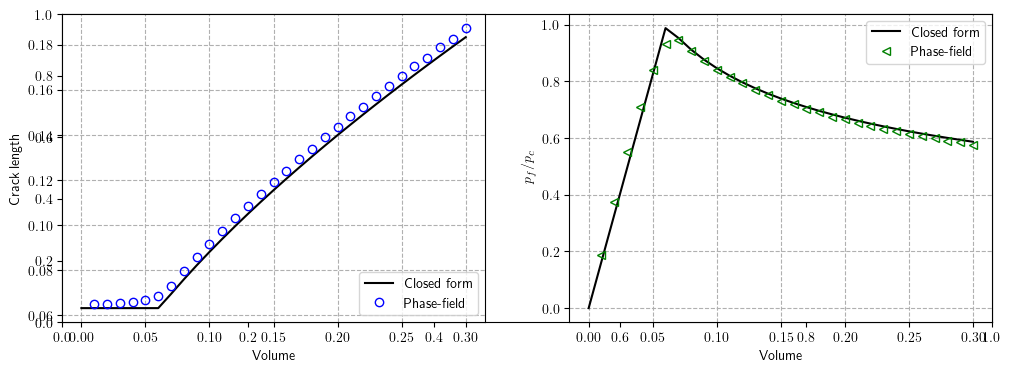

In [10]:
plt.subplots(figsize=(12, 4))
plt.subplot(1, 2, 1)
fluid_volume = []
surface_energy = []
# Open the file for reading
with (out_dir / "log.txt").open() as fd:
    # Iterate over the lines
    for _i, line in enumerate(fd):
        match_surface_energy = re.search(
            r"""Surface energy: (\d+\.\d*) Pressure work: (\d+\.\d*)  at time: (\d+\.\d*)""",
            line,
        )
        if match_surface_energy:
            surface_energy.append(float(match_surface_energy.group(1)))
            fluid_volume.append(float(match_surface_energy.group(3)))

plt.grid(linestyle="dashed")
plt.xlabel("Volume")
plt.ylabel("Crack length")
plt.plot(fluidVolume_analytical, length_analytical, "black", label="Closed form")
plt.plot(
    fluid_volume,
    np.array(surface_energy[:]) / Gc_ref / 2,
    "bo",
    fillstyle="none",
    label="Phase-field",
)
legend = plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
fluid_volume = []
pressure = []
# Open the file for reading
with (out_dir / "log.txt").open() as fd:
    # Iterate over the lines
    for _i, line in enumerate(fd):
        match_pressure = re.search(
            r"""Pressure: (\d+\.\d*) at time: (\d+\.\d*)""", line
        )
        if match_pressure:
            fluid_volume.append(float(match_pressure.group(2)))
            pressure.append(float(match_pressure.group(1)))


plt.xlabel("Volume")
plt.ylabel("$p_f/p_c$")
plt.plot(fluidVolume_analytical, pressure_analytical, "black", label="Closed form")
plt.plot(
    np.array(fluid_volume[:]),
    np.array(pressure[:]) / P_c,
    "g<",
    fillstyle="none",
    label="Phase-field",
)
plt.grid(linestyle="dashed")
legend = plt.legend(loc="upper right")
plt.show()

DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/03/4c/034c697e4966133bcd6756494b8f530a.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/24/23/2423c9cc8e1075dd3812c89f524ceaa9.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/67/81/6781b2b3fa4a8d051cd4be1ebfa6cf8b.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/e1/95/e19591c58e6d033b61236446e1e642c8.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/50/fd/50fdb2316153d1041cb27e8f7c31ee36.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/a1/d5/a1d5dcbbea8fe443ea69f44b9cdd14fa.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/0d/f2/0df2d513d139a1e7c0f94bf5728a067b.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/ee/19/ee1984d0ddaedebd6a44331208e5efb3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/6c/9e/6c9e852699a764721cc299f99eb90573.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/d0/d3/d0d3b0683482935c7a76065861ec9419.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/58/d9/58d9a487f5fba1c1e4c3f6b2207013e3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/98/c9/98c9b8fe9f1d8697d86377fa8c62962d.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/38/a0/38a03fcf6b2abfae72206b2821a254ec.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/53/56/5356f6f7196cf08a8335bf6cc9a7c454.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/4c/f1/4cf178168dad8deab6cc568ca016e994.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/34/74/3474246c5667a1943923141978d23c3a.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/e5/84e5bc723afbadf8c0b55a9f33281fe1.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/50/72/5072e23f5e5ce59679a8b62884de426d.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/f2/c6/f2c6ad0f02cef9e8a87728106b9ccd29.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/7c/8f/7c8fc8fee5ab82aeeaf6dd954cd5feb3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/2d/84/2d84808fb62fe6c38d400d3ac2dda4e0.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.dviread:opening tfm file /usr/share/texmf-dist/fonts/tfm/public/cm/cmss12.tfm


DEBUG:matplotlib.dviread:lh=18, bc=0, ec=127, nw=54, nh=16, nd=11


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/f2/20/f220c92d0fd525a92de14ff835c5c109.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.dviread:opening tfm file /usr/share/texmf-dist/fonts/tfm/public/cm/cmsy9.tfm


DEBUG:matplotlib.dviread:lh=18, bc=0, ec=127, nw=43, nh=15, nd=15


DEBUG:matplotlib.dviread:opening tfm file /usr/share/texmf-dist/fonts/tfm/public/cm/cmmi9.tfm


DEBUG:matplotlib.dviread:lh=18, bc=0, ec=127, nw=97, nh=15, nd=9


DEBUG:matplotlib.dviread:opening tfm file /usr/share/texmf-dist/fonts/tfm/public/cm/cmr7.tfm


DEBUG:matplotlib.dviread:lh=18, bc=0, ec=127, nw=38, nh=16, nd=9


DEBUG:matplotlib.dviread:opening tfm file /usr/share/texmf-dist/fonts/tfm/public/cm/cmsy10.tfm


DEBUG:matplotlib.dviread:lh=18, bc=0, ec=127, nw=44, nh=15, nd=16


DEBUG:matplotlib.dviread:opening tfm file /usr/share/texmf-dist/fonts/tfm/public/cm/cmr12.tfm


DEBUG:matplotlib.dviread:lh=18, bc=0, ec=127, nw=34, nh=16, nd=10


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/1d/d7/1dd7b3300f8b60957054f1a3f1e897a3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/4f/844f707e0917555faafa721cd5105dbd.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/03/4c/034c697e4966133bcd6756494b8f530a.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/24/23/2423c9cc8e1075dd3812c89f524ceaa9.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/67/81/6781b2b3fa4a8d051cd4be1ebfa6cf8b.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/e1/95/e19591c58e6d033b61236446e1e642c8.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/50/fd/50fdb2316153d1041cb27e8f7c31ee36.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/a1/d5/a1d5dcbbea8fe443ea69f44b9cdd14fa.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/03/4c/034c697e4966133bcd6756494b8f530a.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/24/23/2423c9cc8e1075dd3812c89f524ceaa9.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/67/81/6781b2b3fa4a8d051cd4be1ebfa6cf8b.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/e1/95/e19591c58e6d033b61236446e1e642c8.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/50/fd/50fdb2316153d1041cb27e8f7c31ee36.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/a1/d5/a1d5dcbbea8fe443ea69f44b9cdd14fa.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/03/4c/034c697e4966133bcd6756494b8f530a.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/24/23/2423c9cc8e1075dd3812c89f524ceaa9.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/67/81/6781b2b3fa4a8d051cd4be1ebfa6cf8b.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/e1/95/e19591c58e6d033b61236446e1e642c8.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/50/fd/50fdb2316153d1041cb27e8f7c31ee36.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/a1/d5/a1d5dcbbea8fe443ea69f44b9cdd14fa.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/0d/f2/0df2d513d139a1e7c0f94bf5728a067b.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/ee/19/ee1984d0ddaedebd6a44331208e5efb3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/6c/9e/6c9e852699a764721cc299f99eb90573.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/d0/d3/d0d3b0683482935c7a76065861ec9419.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/58/d9/58d9a487f5fba1c1e4c3f6b2207013e3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/98/c9/98c9b8fe9f1d8697d86377fa8c62962d.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/38/a0/38a03fcf6b2abfae72206b2821a254ec.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/0d/f2/0df2d513d139a1e7c0f94bf5728a067b.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/ee/19/ee1984d0ddaedebd6a44331208e5efb3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/6c/9e/6c9e852699a764721cc299f99eb90573.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/d0/d3/d0d3b0683482935c7a76065861ec9419.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/58/d9/58d9a487f5fba1c1e4c3f6b2207013e3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/98/c9/98c9b8fe9f1d8697d86377fa8c62962d.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/38/a0/38a03fcf6b2abfae72206b2821a254ec.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/53/56/5356f6f7196cf08a8335bf6cc9a7c454.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/53/56/5356f6f7196cf08a8335bf6cc9a7c454.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/4c/f1/4cf178168dad8deab6cc568ca016e994.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/34/74/3474246c5667a1943923141978d23c3a.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/e5/84e5bc723afbadf8c0b55a9f33281fe1.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/50/72/5072e23f5e5ce59679a8b62884de426d.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/f2/c6/f2c6ad0f02cef9e8a87728106b9ccd29.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/7c/8f/7c8fc8fee5ab82aeeaf6dd954cd5feb3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 45


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 98 14


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 124 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 145 53


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/4c/f1/4cf178168dad8deab6cc568ca016e994.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 54


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/34/74/3474246c5667a1943923141978d23c3a.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 36


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 89 11


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 112 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 133 46


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/e5/84e5bc723afbadf8c0b55a9f33281fe1.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 39


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 92 12


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 116 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 137 55


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/50/72/5072e23f5e5ce59679a8b62884de426d.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 42


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 95 13


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 120 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 141 54


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/f2/c6/f2c6ad0f02cef9e8a87728106b9ccd29.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 45


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 98 14


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 124 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 145 70


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/7c/8f/7c8fc8fee5ab82aeeaf6dd954cd5feb3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/2d/84/2d84808fb62fe6c38d400d3ac2dda4e0.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/f2/20/f220c92d0fd525a92de14ff835c5c109.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 591


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/f2/20/f220c92d0fd525a92de14ff835c5c109.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/0d/f2/0df2d513d139a1e7c0f94bf5728a067b.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/ee/19/ee1984d0ddaedebd6a44331208e5efb3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/6c/9e/6c9e852699a764721cc299f99eb90573.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/d0/d3/d0d3b0683482935c7a76065861ec9419.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/58/d9/58d9a487f5fba1c1e4c3f6b2207013e3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/98/c9/98c9b8fe9f1d8697d86377fa8c62962d.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/38/a0/38a03fcf6b2abfae72206b2821a254ec.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/53/56/5356f6f7196cf08a8335bf6cc9a7c454.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/4c/f1/4cf178168dad8deab6cc568ca016e994.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/34/74/3474246c5667a1943923141978d23c3a.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/84/e5/84e5bc723afbadf8c0b55a9f33281fe1.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/50/72/5072e23f5e5ce59679a8b62884de426d.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/f2/c6/f2c6ad0f02cef9e8a87728106b9ccd29.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/7c/8f/7c8fc8fee5ab82aeeaf6dd954cd5feb3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/1d/d7/1dd7b3300f8b60957054f1a3f1e897a3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13


DEBUG:PIL.PngImagePlugin:STREAM b'PLTE' 41 48


DEBUG:PIL.PngImagePlugin:STREAM b'tRNS' 101 15


DEBUG:PIL.PngImagePlugin:STREAM b'pHYs' 128 9


DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 149 576


DEBUG:matplotlib.texmanager:family: serif, package: \usepackage{type1ec}, font: Computer Modern Roman, skipped: DejaVu Serif, Bitstream Vera Serif


DEBUG:matplotlib.texmanager:family: sans-serif, package: \usepackage{type1ec}, font: Computer Modern Sans Serif, skipped: DejaVu Sans, Bitstream Vera Sans


DEBUG:matplotlib.texmanager:family: cursive, package: \usepackage{chancery}, font: Zapf Chancery, skipped: Apple Chancery, Textile


DEBUG:matplotlib.texmanager:family: monospace, package: \usepackage{type1ec}, font: Computer Modern Typewriter, skipped: DejaVu Sans Mono, Bitstream Vera Sans Mono


DEBUG:matplotlib.dviread:Dvi: /var/lib/gitlab-runner/.cache/matplotlib/tex.cache/1d/d7/1dd7b3300f8b60957054f1a3f1e897a3.dvi


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: header=l3backend-dvips.pro


DEBUG:matplotlib.dviread:Dvi._xxx: encountered special: papersize=5203.43999pt,5203.43999pt


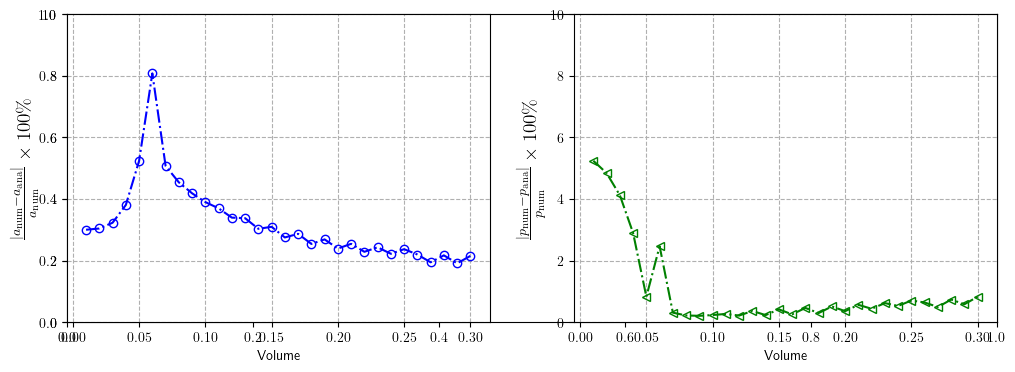

In [11]:
plt.subplots(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.grid(linestyle="dashed")
plt.plot(
    fluidVolume_analytical[1:],
    (
        abs(length_analytical[1:] - np.array(surface_energy[:]) / (2 * Gc_ref))
        / (np.array(surface_energy[:]) / (2 * Gc_ref))
    )
    * 100,
    "-.ob",
    fillstyle="none",
    label="Closed form",
)
plt.ylim([0.0, 10])
plt.xlabel("Volume")
plt.ylabel(
    r"$\frac{|a_\mathrm{num}-{a}_\mathrm{ana}|}{{a}_\mathrm{num}}\times 100\%$",
    fontsize=14,
)

plt.subplot(1, 2, 2)
plt.grid(linestyle="dashed")
plt.plot(
    fluidVolume_analytical[1:],
    (abs(pressure_analytical[1:] - np.array(pressure[:]) / P_c) / pressure[:]) * 100,
    "-.<g",
    fillstyle="none",
    label="Closed form",
)
plt.ylim([0.0, 10])
plt.xlabel("Volume")
plt.ylabel(
    r"$\frac{|p_\mathrm{num}-{p}_\mathrm{ana}|}{{p}_\mathrm{num}}\times 100\%$",
    fontsize=14,
)
plt.show()

In order to reduce computation time, we perform the simulation with a coarse mesh; the results for the $\texttt{AT}_1$ Model with a mesh size of $h=0.001$ are provided below.

$\texttt{AT}_1$ Model:

![Phase field versus analytical solution for fracture length and pressure evolution](./figures/AT1_VolDev_h0p001.png#one-half "Phase field versus analytical solution for fracture length and pressure evolution, $\texttt{AT}_1$.")

![Error between the Phase field and analytical solution for fracture length and pressure evolution.](./figures/error_AT1_VolDev_h0p001.png#one-half "Error between the Phase field and analytical solution for fracture length and pressure evolution, $\texttt{AT}_1$.")

## Hydraulic Fracturing Animation  (Using Phase Field Approach)

In [12]:
filename = f"results_h_{h:0.4f}_{phasefield_model}"
reader = pv.get_reader(f"{out_dir}/" + filename + ".pvd")

plotter = pv.Plotter(shape=(1, 2), border=False)
plotter.open_gif(f"{out_dir}/Kregime_Propagating.gif")
for time_value in reader.time_values:
    reader.set_active_time_value(time_value)
    mesh = reader.read()[0]
    sargs = {
        "title": "Phase field",
        "title_font_size": 16,
        "label_font_size": 12,
        "n_labels": 5,
        "position_x": 0.25,
        "position_y": 0.15,
        "fmt": "%.1f",
        "width": 0.5,
    }
    p = pv.Plotter(shape=(1, 2), border=False)
    clim = [0, 1.0]
    points = mesh.point_data["phasefield"].shape[0]
    xs = mesh.points[:, 0]
    ys = mesh.points[:, 1]
    pf = mesh.point_data["phasefield"]
    plotter.clear()
    plotter.add_mesh(
        mesh,
        scalars=pf,
        show_scalar_bar=True,
        colormap="coolwarm",
        clim=clim,
        scalar_bar_args=sargs,
        lighting=False,
    )
    plotter.add_text(f"Time: {time_value:0.02f}", color="black")

    plotter.view_xy()
    plotter.write_frame()

plotter.close()

DEBUG:PIL.Image:Importing BlpImagePlugin


DEBUG:PIL.Image:Importing BmpImagePlugin


DEBUG:PIL.Image:Importing BufrStubImagePlugin


DEBUG:PIL.Image:Importing CurImagePlugin


DEBUG:PIL.Image:Importing DcxImagePlugin


DEBUG:PIL.Image:Importing DdsImagePlugin


DEBUG:PIL.Image:Importing EpsImagePlugin


DEBUG:PIL.Image:Importing FitsImagePlugin


DEBUG:PIL.Image:Importing FliImagePlugin


DEBUG:PIL.Image:Importing FpxImagePlugin


DEBUG:PIL.Image:Image: failed to import FpxImagePlugin: No module named 'olefile'


DEBUG:PIL.Image:Importing FtexImagePlugin


DEBUG:PIL.Image:Importing GbrImagePlugin


DEBUG:PIL.Image:Importing GifImagePlugin


DEBUG:PIL.Image:Importing GribStubImagePlugin


DEBUG:PIL.Image:Importing Hdf5StubImagePlugin


DEBUG:PIL.Image:Importing IcnsImagePlugin


DEBUG:PIL.Image:Importing IcoImagePlugin


DEBUG:PIL.Image:Importing ImImagePlugin


DEBUG:PIL.Image:Importing ImtImagePlugin


DEBUG:PIL.Image:Importing IptcImagePlugin


DEBUG:PIL.Image:Importing JpegImagePlugin


DEBUG:PIL.Image:Importing Jpeg2KImagePlugin


DEBUG:PIL.Image:Importing McIdasImagePlugin


DEBUG:PIL.Image:Importing MicImagePlugin


DEBUG:PIL.Image:Image: failed to import MicImagePlugin: No module named 'olefile'


DEBUG:PIL.Image:Importing MpegImagePlugin


DEBUG:PIL.Image:Importing MpoImagePlugin


DEBUG:PIL.Image:Importing MspImagePlugin


DEBUG:PIL.Image:Importing PalmImagePlugin


DEBUG:PIL.Image:Importing PcdImagePlugin


DEBUG:PIL.Image:Importing PcxImagePlugin


DEBUG:PIL.Image:Importing PdfImagePlugin


DEBUG:PIL.Image:Importing PixarImagePlugin


DEBUG:PIL.Image:Importing PngImagePlugin


DEBUG:PIL.Image:Importing PpmImagePlugin


DEBUG:PIL.Image:Importing PsdImagePlugin


DEBUG:PIL.Image:Importing QoiImagePlugin


DEBUG:PIL.Image:Importing SgiImagePlugin


DEBUG:PIL.Image:Importing SpiderImagePlugin


DEBUG:PIL.Image:Importing SunImagePlugin


DEBUG:PIL.Image:Importing TgaImagePlugin


DEBUG:PIL.Image:Importing TiffImagePlugin


DEBUG:PIL.Image:Importing WebPImagePlugin


DEBUG:PIL.Image:Importing WmfImagePlugin


DEBUG:PIL.Image:Importing XbmImagePlugin


DEBUG:PIL.Image:Importing XpmImagePlugin


DEBUG:PIL.Image:Importing XVThumbImagePlugin


## Phase Field Profile at Last Time Step

In [13]:
mesh = reader.read()[0]

points = mesh.point_data["phasefield"].shape[0]
xs = mesh.points[:, 0]
ys = mesh.points[:, 1]
pf = mesh.point_data["phasefield"]

clim = [0, 1.0]
sargs = {
    "title": "Phase field",
    "title_font_size": 16,
    "label_font_size": 12,
    "n_labels": 5,
    "position_x": 0.25,
    "position_y": 0.0,
    "fmt": "%.1f",
    "width": 0.5,
}
plotter = pv.Plotter(shape=(1, 2), border=False)
plotter.add_mesh(
    mesh,
    scalars=pf,
    show_edges=False,
    show_scalar_bar=True,
    colormap="coolwarm",
    clim=clim,
    scalar_bar_args=sargs,
    lighting=False,
)

plotter.view_xy()
plotter.camera.zoom(1.5)
plotter.window_size = [1000, 500]
plotter.show()

/var/lib/gitlab-runner/builds/vZ6vnZiU/1/ogs/build/release-petsc/.venv/lib/python3.12/site-packages/trame_vuetify/widgets/vuetify.py:495: SyntaxWarning: invalid escape sequence '\|'
  """
INFO:trame_server.utils.namespace:Translator(prefix=None)


INFO:wslink.backends.aiohttp:awaiting runner setup


INFO:wslink.backends.aiohttp:awaiting site startup


DEBUG:pyvista.trame.jupyter:Server ready: <trame_server.core.Server object at 0x78d659fa2fc0>


INFO:wslink.backends.aiohttp:Print WSLINK_READY_MSG


INFO:wslink.backends.aiohttp:Schedule auto shutdown with timout 0


INFO:wslink.backends.aiohttp:awaiting running future


INFO:trame_server.controller:trigger(trigger__1)


INFO:trame_server.controller:trigger(trigger__2)


INFO:trame_server.controller:trigger(P_0x78d659fa15e0_31Camera)


INFO:trame_server.controller:trigger(P_0x78d659fa15e0_31AnimateStart)


INFO:trame_server.controller:trigger(P_0x78d659fa15e0_31AnimateStop)


INFO:trame_client.widgets.core:js_key = class


INFO:trame_client.widgets.core:js_key = style


INFO:trame_client.widgets.core:js_key = fluid


INFO:trame_client.widgets.core:js_key = class


INFO:trame_client.widgets.core:before: class = { 'rounded-circle': !P_0x78d659fa15e0_31_show_ui }


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token rounded


INFO:trame_server.state:has(rounded => rounded) = False


INFO:trame_server.utils.namespace:(prefix=None) token -


INFO:trame_server.state:has(- => -) = False


INFO:trame_server.utils.namespace:(prefix=None) token circle


INFO:trame_server.state:has(circle => circle) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token :


INFO:trame_server.state:has(: => :) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token !


INFO:trame_server.state:has(! => !) = False


INFO:trame_server.utils.namespace:(prefix=None) token P_0x78d659fa15e0_31_show_ui


INFO:trame_server.state:has(P_0x78d659fa15e0_31_show_ui => P_0x78d659fa15e0_31_show_ui) = True


INFO:trame_server.utils.namespace:(prefix=None) translated P_0x78d659fa15e0_31_show_ui


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token }


INFO:trame_server.state:has(} => }) = False


INFO:trame_server.utils.namespace: => { 'rounded-circle': !P_0x78d659fa15e0_31_show_ui }


INFO:trame_client.widgets.core:after: class = { 'rounded-circle': !P_0x78d659fa15e0_31_show_ui }


INFO:trame_client.widgets.core:js_key = style


INFO:trame_client.widgets.core:js_key = class


INFO:trame_client.widgets.core:js_key = style


INFO:trame_client.widgets.core:js_key = location


INFO:trame_client.widgets.core:js_key = v-slot:activator


INFO:trame_client.widgets.core:before: v-slot:activator = { props }


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token }


INFO:trame_server.state:has(} => }) = False


INFO:trame_server.utils.namespace: => { props }


INFO:trame_client.widgets.core:after: v-slot:activator = { props }


INFO:trame_client.widgets.core:js_key = v-bind


INFO:trame_client.widgets.core:before: v-bind = props


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace: => props


INFO:trame_client.widgets.core:after: v-bind = props


INFO:trame_client.widgets.core:js_key = size


INFO:trame_client.widgets.core:js_key = variant


INFO:trame_client.widgets.core:js_key = icon


INFO:trame_server.utils.namespace:(prefix=None) token P_0x78d659fa15e0_31_show_ui=


INFO:trame_server.state:has(P_0x78d659fa15e0_31_show_ui= => P_0x78d659fa15e0_31_show_ui=) = False


INFO:trame_server.utils.namespace:(prefix=None) token !


INFO:trame_server.state:has(! => !) = False


INFO:trame_server.utils.namespace:(prefix=None) token P_0x78d659fa15e0_31_show_ui


INFO:trame_server.state:has(P_0x78d659fa15e0_31_show_ui => P_0x78d659fa15e0_31_show_ui) = True


INFO:trame_server.utils.namespace:(prefix=None) translated P_0x78d659fa15e0_31_show_ui


INFO:trame_server.utils.namespace: => P_0x78d659fa15e0_31_show_ui=!P_0x78d659fa15e0_31_show_ui


INFO:trame_server.utils.namespace: token mdi-dots-vertical


INFO:trame_server.utils.namespace: token {


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace: => {


INFO:trame_server.utils.namespace: token { P_0x78d659fa15e0_31_show_ui ? 'Hide' : 'Show' }


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token P_0x78d659fa15e0_31_show_ui


INFO:trame_server.state:has(P_0x78d659fa15e0_31_show_ui => P_0x78d659fa15e0_31_show_ui) = True


INFO:trame_server.utils.namespace:(prefix=None) translated P_0x78d659fa15e0_31_show_ui


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token ?


INFO:trame_server.state:has(? => ?) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token Hide


INFO:trame_server.state:has(Hide => Hide) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token :


INFO:trame_server.state:has(: => :) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token Show


INFO:trame_server.state:has(Show => Show) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token }


INFO:trame_server.state:has(} => }) = False


INFO:trame_server.utils.namespace: => { P_0x78d659fa15e0_31_show_ui ? 'Hide' : 'Show' }


INFO:trame_server.utils.namespace: token } menu


INFO:trame_client.widgets.core:js_key = class


INFO:trame_client.widgets.core:js_key = style


INFO:trame_client.widgets.core:js_key = v-show


INFO:trame_client.widgets.core:before: v-show = P_0x78d659fa15e0_31_show_ui


INFO:trame_server.utils.namespace:(prefix=None) token P_0x78d659fa15e0_31_show_ui


INFO:trame_server.state:has(P_0x78d659fa15e0_31_show_ui => P_0x78d659fa15e0_31_show_ui) = True


INFO:trame_server.utils.namespace:(prefix=None) translated P_0x78d659fa15e0_31_show_ui


INFO:trame_server.utils.namespace: => P_0x78d659fa15e0_31_show_ui


INFO:trame_client.widgets.core:after: v-show = P_0x78d659fa15e0_31_show_ui


INFO:trame_client.widgets.core:js_key = class


INFO:trame_client.widgets.core:js_key = vertical


INFO:trame_client.widgets.core:js_key = location


INFO:trame_client.widgets.core:js_key = v-slot:activator


INFO:trame_client.widgets.core:before: v-slot:activator = { props }


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token }


INFO:trame_server.state:has(} => }) = False


INFO:trame_server.utils.namespace: => { props }


INFO:trame_client.widgets.core:after: v-slot:activator = { props }


INFO:trame_client.widgets.core:js_key = v-bind


INFO:trame_client.widgets.core:before: v-bind = props


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace: => props


INFO:trame_client.widgets.core:after: v-bind = props


INFO:trame_client.widgets.core:js_key = size


INFO:trame_client.widgets.core:js_key = variant


INFO:trame_client.widgets.core:js_key = icon


INFO:trame_server.controller:trigger(trigger__3)


INFO:trame_server.utils.namespace: token mdi-arrow-expand-all


INFO:trame_server.utils.namespace: token Reset Camera


INFO:trame_client.widgets.core:js_key = class


INFO:trame_client.widgets.core:js_key = vertical


INFO:trame_client.widgets.core:js_key = location


INFO:trame_client.widgets.core:js_key = v-slot:activator


INFO:trame_client.widgets.core:before: v-slot:activator = { props }


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token }


INFO:trame_server.state:has(} => }) = False


INFO:trame_server.utils.namespace: => { props }


INFO:trame_client.widgets.core:after: v-slot:activator = { props }


INFO:trame_client.widgets.core:js_key = v-bind


INFO:trame_client.widgets.core:before: v-bind = props


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace: => props


INFO:trame_client.widgets.core:after: v-bind = props


INFO:trame_client.widgets.core:js_key = size


INFO:trame_client.widgets.core:js_key = variant


INFO:trame_client.widgets.core:js_key = icon


INFO:trame_server.controller:trigger(trigger__4)


INFO:trame_server.utils.namespace: token mdi-axis-arrow


INFO:trame_server.utils.namespace: token Perspective view


INFO:trame_client.widgets.core:js_key = location


INFO:trame_client.widgets.core:js_key = v-slot:activator


INFO:trame_client.widgets.core:before: v-slot:activator = { props }


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token }


INFO:trame_server.state:has(} => }) = False


INFO:trame_server.utils.namespace: => { props }


INFO:trame_client.widgets.core:after: v-slot:activator = { props }


INFO:trame_client.widgets.core:js_key = v-bind


INFO:trame_client.widgets.core:before: v-bind = props


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace: => props


INFO:trame_client.widgets.core:after: v-bind = props


INFO:trame_client.widgets.core:js_key = size


INFO:trame_client.widgets.core:js_key = variant


INFO:trame_client.widgets.core:js_key = icon


INFO:trame_server.controller:trigger(trigger__5)


INFO:trame_server.utils.namespace: token mdi-axis-x-arrow


INFO:trame_server.utils.namespace: token Reset Camera X


INFO:trame_client.widgets.core:js_key = location


INFO:trame_client.widgets.core:js_key = v-slot:activator


INFO:trame_client.widgets.core:before: v-slot:activator = { props }


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token }


INFO:trame_server.state:has(} => }) = False


INFO:trame_server.utils.namespace: => { props }


INFO:trame_client.widgets.core:after: v-slot:activator = { props }


INFO:trame_client.widgets.core:js_key = v-bind


INFO:trame_client.widgets.core:before: v-bind = props


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace: => props


INFO:trame_client.widgets.core:after: v-bind = props


INFO:trame_client.widgets.core:js_key = size


INFO:trame_client.widgets.core:js_key = variant


INFO:trame_client.widgets.core:js_key = icon


INFO:trame_server.controller:trigger(trigger__6)


INFO:trame_server.utils.namespace: token mdi-axis-y-arrow


INFO:trame_server.utils.namespace: token Reset Camera Y


INFO:trame_client.widgets.core:js_key = location


INFO:trame_client.widgets.core:js_key = v-slot:activator


INFO:trame_client.widgets.core:before: v-slot:activator = { props }


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token }


INFO:trame_server.state:has(} => }) = False


INFO:trame_server.utils.namespace: => { props }


INFO:trame_client.widgets.core:after: v-slot:activator = { props }


INFO:trame_client.widgets.core:js_key = v-bind


INFO:trame_client.widgets.core:before: v-bind = props


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace: => props


INFO:trame_client.widgets.core:after: v-bind = props


INFO:trame_client.widgets.core:js_key = size


INFO:trame_client.widgets.core:js_key = variant


INFO:trame_client.widgets.core:js_key = icon


INFO:trame_server.controller:trigger(trigger__7)


INFO:trame_server.utils.namespace: token mdi-axis-z-arrow


INFO:trame_server.utils.namespace: token Reset Camera Z


INFO:trame_client.widgets.core:js_key = class


INFO:trame_client.widgets.core:js_key = vertical


INFO:trame_client.widgets.core:js_key = location


INFO:trame_client.widgets.core:js_key = v-slot:activator


INFO:trame_client.widgets.core:before: v-slot:activator = { props }


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token }


INFO:trame_server.state:has(} => }) = False


INFO:trame_server.utils.namespace: => { props }


INFO:trame_client.widgets.core:after: v-slot:activator = { props }


INFO:trame_client.widgets.core:js_key = v-bind


INFO:trame_client.widgets.core:before: v-bind = props


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace: => props


INFO:trame_client.widgets.core:after: v-bind = props


INFO:trame_client.widgets.core:js_key = v-bind


INFO:trame_client.widgets.core:before: v-bind = props


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace: => props


INFO:trame_client.widgets.core:after: v-bind = props


INFO:trame_client.widgets.core:js_key = class


INFO:trame_client.widgets.core:js_key = v-model


INFO:trame_client.widgets.core:before: v-model = P_0x78d659fa15e0_31_edge_visibility


INFO:trame_server.utils.namespace:(prefix=None) token P_0x78d659fa15e0_31_edge_visibility


INFO:trame_server.state:has(P_0x78d659fa15e0_31_edge_visibility => P_0x78d659fa15e0_31_edge_visibility) = True


INFO:trame_server.utils.namespace:(prefix=None) translated P_0x78d659fa15e0_31_edge_visibility


INFO:trame_server.utils.namespace: => P_0x78d659fa15e0_31_edge_visibility


INFO:trame_client.widgets.core:after: v-model = P_0x78d659fa15e0_31_edge_visibility


INFO:trame_client.widgets.core:js_key = density


INFO:trame_client.widgets.core:js_key = hideDetails


INFO:trame_client.widgets.core:js_key = falseIcon


INFO:trame_client.widgets.core:js_key = trueIcon


INFO:trame_server.utils.namespace: token Toggle edge visibility ({


INFO:trame_server.utils.namespace: token { P_0x78d659fa15e0_31_edge_visibility ? 'on' : 'off' }


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token P_0x78d659fa15e0_31_edge_visibility


INFO:trame_server.state:has(P_0x78d659fa15e0_31_edge_visibility => P_0x78d659fa15e0_31_edge_visibility) = True


INFO:trame_server.utils.namespace:(prefix=None) translated P_0x78d659fa15e0_31_edge_visibility


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token ?


INFO:trame_server.state:has(? => ?) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token on


INFO:trame_server.state:has(on => on) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token :


INFO:trame_server.state:has(: => :) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token off


INFO:trame_server.state:has(off => off) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token }


INFO:trame_server.state:has(} => }) = False


INFO:trame_server.utils.namespace: => { P_0x78d659fa15e0_31_edge_visibility ? 'on' : 'off' }


INFO:trame_server.utils.namespace: token })


INFO:trame_client.widgets.core:js_key = location


INFO:trame_client.widgets.core:js_key = v-slot:activator


INFO:trame_client.widgets.core:before: v-slot:activator = { props }


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token }


INFO:trame_server.state:has(} => }) = False


INFO:trame_server.utils.namespace: => { props }


INFO:trame_client.widgets.core:after: v-slot:activator = { props }


INFO:trame_client.widgets.core:js_key = v-bind


INFO:trame_client.widgets.core:before: v-bind = props


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace: => props


INFO:trame_client.widgets.core:after: v-bind = props


INFO:trame_client.widgets.core:js_key = v-bind


INFO:trame_client.widgets.core:before: v-bind = props


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace: => props


INFO:trame_client.widgets.core:after: v-bind = props


INFO:trame_client.widgets.core:js_key = class


INFO:trame_client.widgets.core:js_key = v-model


INFO:trame_client.widgets.core:before: v-model = P_0x78d659fa15e0_31_outline_visibility


INFO:trame_server.utils.namespace:(prefix=None) token P_0x78d659fa15e0_31_outline_visibility


INFO:trame_server.state:has(P_0x78d659fa15e0_31_outline_visibility => P_0x78d659fa15e0_31_outline_visibility) = True


INFO:trame_server.utils.namespace:(prefix=None) translated P_0x78d659fa15e0_31_outline_visibility


INFO:trame_server.utils.namespace: => P_0x78d659fa15e0_31_outline_visibility


INFO:trame_client.widgets.core:after: v-model = P_0x78d659fa15e0_31_outline_visibility


INFO:trame_client.widgets.core:js_key = density


INFO:trame_client.widgets.core:js_key = hideDetails


INFO:trame_client.widgets.core:js_key = falseIcon


INFO:trame_client.widgets.core:js_key = trueIcon


INFO:trame_server.utils.namespace: token Toggle bounding box ({


INFO:trame_server.utils.namespace: token { P_0x78d659fa15e0_31_outline_visibility ? 'on' : 'off' }


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token P_0x78d659fa15e0_31_outline_visibility


INFO:trame_server.state:has(P_0x78d659fa15e0_31_outline_visibility => P_0x78d659fa15e0_31_outline_visibility) = True


INFO:trame_server.utils.namespace:(prefix=None) translated P_0x78d659fa15e0_31_outline_visibility


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token ?


INFO:trame_server.state:has(? => ?) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token on


INFO:trame_server.state:has(on => on) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token :


INFO:trame_server.state:has(: => :) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token off


INFO:trame_server.state:has(off => off) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token }


INFO:trame_server.state:has(} => }) = False


INFO:trame_server.utils.namespace: => { P_0x78d659fa15e0_31_outline_visibility ? 'on' : 'off' }


INFO:trame_server.utils.namespace: token })


INFO:trame_client.widgets.core:js_key = location


INFO:trame_client.widgets.core:js_key = v-slot:activator


INFO:trame_client.widgets.core:before: v-slot:activator = { props }


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token }


INFO:trame_server.state:has(} => }) = False


INFO:trame_server.utils.namespace: => { props }


INFO:trame_client.widgets.core:after: v-slot:activator = { props }


INFO:trame_client.widgets.core:js_key = v-bind


INFO:trame_client.widgets.core:before: v-bind = props


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace: => props


INFO:trame_client.widgets.core:after: v-bind = props


INFO:trame_client.widgets.core:js_key = v-bind


INFO:trame_client.widgets.core:before: v-bind = props


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace: => props


INFO:trame_client.widgets.core:after: v-bind = props


INFO:trame_client.widgets.core:js_key = class


INFO:trame_client.widgets.core:js_key = v-model


INFO:trame_client.widgets.core:before: v-model = P_0x78d659fa15e0_31_grid_visibility


INFO:trame_server.utils.namespace:(prefix=None) token P_0x78d659fa15e0_31_grid_visibility


INFO:trame_server.state:has(P_0x78d659fa15e0_31_grid_visibility => P_0x78d659fa15e0_31_grid_visibility) = True


INFO:trame_server.utils.namespace:(prefix=None) translated P_0x78d659fa15e0_31_grid_visibility


INFO:trame_server.utils.namespace: => P_0x78d659fa15e0_31_grid_visibility


INFO:trame_client.widgets.core:after: v-model = P_0x78d659fa15e0_31_grid_visibility


INFO:trame_client.widgets.core:js_key = density


INFO:trame_client.widgets.core:js_key = hideDetails


INFO:trame_client.widgets.core:js_key = falseIcon


INFO:trame_client.widgets.core:js_key = trueIcon


INFO:trame_server.utils.namespace: token Toggle ruler ({


INFO:trame_server.utils.namespace: token { P_0x78d659fa15e0_31_grid_visibility ? 'on' : 'off' }


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token P_0x78d659fa15e0_31_grid_visibility


INFO:trame_server.state:has(P_0x78d659fa15e0_31_grid_visibility => P_0x78d659fa15e0_31_grid_visibility) = True


INFO:trame_server.utils.namespace:(prefix=None) translated P_0x78d659fa15e0_31_grid_visibility


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token ?


INFO:trame_server.state:has(? => ?) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token on


INFO:trame_server.state:has(on => on) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token :


INFO:trame_server.state:has(: => :) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token off


INFO:trame_server.state:has(off => off) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token }


INFO:trame_server.state:has(} => }) = False


INFO:trame_server.utils.namespace: => { P_0x78d659fa15e0_31_grid_visibility ? 'on' : 'off' }


INFO:trame_server.utils.namespace: token })


INFO:trame_client.widgets.core:js_key = location


INFO:trame_client.widgets.core:js_key = v-slot:activator


INFO:trame_client.widgets.core:before: v-slot:activator = { props }


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token }


INFO:trame_server.state:has(} => }) = False


INFO:trame_server.utils.namespace: => { props }


INFO:trame_client.widgets.core:after: v-slot:activator = { props }


INFO:trame_client.widgets.core:js_key = v-bind


INFO:trame_client.widgets.core:before: v-bind = props


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace: => props


INFO:trame_client.widgets.core:after: v-bind = props


INFO:trame_client.widgets.core:js_key = v-bind


INFO:trame_client.widgets.core:before: v-bind = props


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace: => props


INFO:trame_client.widgets.core:after: v-bind = props


INFO:trame_client.widgets.core:js_key = class


INFO:trame_client.widgets.core:js_key = v-model


INFO:trame_client.widgets.core:before: v-model = P_0x78d659fa15e0_31_axis_visiblity


INFO:trame_server.utils.namespace:(prefix=None) token P_0x78d659fa15e0_31_axis_visiblity


INFO:trame_server.state:has(P_0x78d659fa15e0_31_axis_visiblity => P_0x78d659fa15e0_31_axis_visiblity) = True


INFO:trame_server.utils.namespace:(prefix=None) translated P_0x78d659fa15e0_31_axis_visiblity


INFO:trame_server.utils.namespace: => P_0x78d659fa15e0_31_axis_visiblity


INFO:trame_client.widgets.core:after: v-model = P_0x78d659fa15e0_31_axis_visiblity


INFO:trame_client.widgets.core:js_key = density


INFO:trame_client.widgets.core:js_key = hideDetails


INFO:trame_client.widgets.core:js_key = falseIcon


INFO:trame_client.widgets.core:js_key = trueIcon


INFO:trame_server.utils.namespace: token Toggle axis ({


INFO:trame_server.utils.namespace: token { P_0x78d659fa15e0_31_axis_visiblity ? 'on' : 'off' }


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token P_0x78d659fa15e0_31_axis_visiblity


INFO:trame_server.state:has(P_0x78d659fa15e0_31_axis_visiblity => P_0x78d659fa15e0_31_axis_visiblity) = True


INFO:trame_server.utils.namespace:(prefix=None) translated P_0x78d659fa15e0_31_axis_visiblity


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token ?


INFO:trame_server.state:has(? => ?) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token on


INFO:trame_server.state:has(on => on) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token :


INFO:trame_server.state:has(: => :) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token off


INFO:trame_server.state:has(off => off) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token }


INFO:trame_server.state:has(} => }) = False


INFO:trame_server.utils.namespace: => { P_0x78d659fa15e0_31_axis_visiblity ? 'on' : 'off' }


INFO:trame_server.utils.namespace: token })


INFO:trame_client.widgets.core:js_key = class


INFO:trame_client.widgets.core:js_key = vertical


INFO:trame_client.widgets.core:js_key = location


INFO:trame_client.widgets.core:js_key = v-slot:activator


INFO:trame_client.widgets.core:before: v-slot:activator = { props }


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token }


INFO:trame_server.state:has(} => }) = False


INFO:trame_server.utils.namespace: => { props }


INFO:trame_client.widgets.core:after: v-slot:activator = { props }


INFO:trame_client.widgets.core:js_key = v-bind


INFO:trame_client.widgets.core:before: v-bind = props


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace: => props


INFO:trame_client.widgets.core:after: v-bind = props


INFO:trame_client.widgets.core:js_key = v-bind


INFO:trame_client.widgets.core:before: v-bind = props


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace: => props


INFO:trame_client.widgets.core:after: v-bind = props


INFO:trame_client.widgets.core:js_key = class


INFO:trame_client.widgets.core:js_key = v-model


INFO:trame_client.widgets.core:before: v-model = P_0x78d659fa15e0_31_use_server_rendering


INFO:trame_server.utils.namespace:(prefix=None) token P_0x78d659fa15e0_31_use_server_rendering


INFO:trame_server.state:has(P_0x78d659fa15e0_31_use_server_rendering => P_0x78d659fa15e0_31_use_server_rendering) = True


INFO:trame_server.utils.namespace:(prefix=None) translated P_0x78d659fa15e0_31_use_server_rendering


INFO:trame_server.utils.namespace: => P_0x78d659fa15e0_31_use_server_rendering


INFO:trame_client.widgets.core:after: v-model = P_0x78d659fa15e0_31_use_server_rendering


INFO:trame_client.widgets.core:js_key = density


INFO:trame_client.widgets.core:js_key = hideDetails


INFO:trame_client.widgets.core:js_key = falseIcon


INFO:trame_client.widgets.core:js_key = trueIcon


INFO:trame_server.utils.namespace: token Toggle rendering mode ({


INFO:trame_server.utils.namespace: token { P_0x78d659fa15e0_31_use_server_rendering ? 'remote' : 'local' }


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token P_0x78d659fa15e0_31_use_server_rendering


INFO:trame_server.state:has(P_0x78d659fa15e0_31_use_server_rendering => P_0x78d659fa15e0_31_use_server_rendering) = True


INFO:trame_server.utils.namespace:(prefix=None) translated P_0x78d659fa15e0_31_use_server_rendering


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token ?


INFO:trame_server.state:has(? => ?) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token remote


INFO:trame_server.state:has(remote => remote) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token :


INFO:trame_server.state:has(: => :) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token local


INFO:trame_server.state:has(local => local) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token }


INFO:trame_server.state:has(} => }) = False


INFO:trame_server.utils.namespace: => { P_0x78d659fa15e0_31_use_server_rendering ? 'remote' : 'local' }


INFO:trame_server.utils.namespace: token })


INFO:trame_client.widgets.core:js_key = class


INFO:trame_client.widgets.core:js_key = style


INFO:trame_client.widgets.core:js_key = v-show


INFO:trame_client.widgets.core:before: v-show = P_0x78d659fa15e0_31_use_server_rendering


INFO:trame_server.utils.namespace:(prefix=None) token P_0x78d659fa15e0_31_use_server_rendering


INFO:trame_server.state:has(P_0x78d659fa15e0_31_use_server_rendering => P_0x78d659fa15e0_31_use_server_rendering) = True


INFO:trame_server.utils.namespace:(prefix=None) translated P_0x78d659fa15e0_31_use_server_rendering


INFO:trame_server.utils.namespace: => P_0x78d659fa15e0_31_use_server_rendering


INFO:trame_client.widgets.core:after: v-show = P_0x78d659fa15e0_31_use_server_rendering


INFO:trame_client.widgets.core:js_key = location


INFO:trame_client.widgets.core:js_key = v-slot:activator


INFO:trame_client.widgets.core:before: v-slot:activator = { props }


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token }


INFO:trame_server.state:has(} => }) = False


INFO:trame_server.utils.namespace: => { props }


INFO:trame_client.widgets.core:after: v-slot:activator = { props }


INFO:trame_client.widgets.core:js_key = v-bind


INFO:trame_client.widgets.core:before: v-bind = props


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace: => props


INFO:trame_client.widgets.core:after: v-bind = props


INFO:trame_client.widgets.core:js_key = v-bind


INFO:trame_client.widgets.core:before: v-bind = props


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace: => props


INFO:trame_client.widgets.core:after: v-bind = props


INFO:trame_client.widgets.core:js_key = class


INFO:trame_client.widgets.core:js_key = v-model


INFO:trame_client.widgets.core:before: v-model = P_0x78d659fa15e0_31_parallel_projection


INFO:trame_server.utils.namespace:(prefix=None) token P_0x78d659fa15e0_31_parallel_projection


INFO:trame_server.state:has(P_0x78d659fa15e0_31_parallel_projection => P_0x78d659fa15e0_31_parallel_projection) = True


INFO:trame_server.utils.namespace:(prefix=None) translated P_0x78d659fa15e0_31_parallel_projection


INFO:trame_server.utils.namespace: => P_0x78d659fa15e0_31_parallel_projection


INFO:trame_client.widgets.core:after: v-model = P_0x78d659fa15e0_31_parallel_projection


INFO:trame_client.widgets.core:js_key = density


INFO:trame_client.widgets.core:js_key = hideDetails


INFO:trame_client.widgets.core:js_key = falseIcon


INFO:trame_client.widgets.core:js_key = trueIcon


INFO:trame_server.utils.namespace: token Toggle parallel projection ({


INFO:trame_server.utils.namespace: token { P_0x78d659fa15e0_31_parallel_projection ? 'on' : 'off' }


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token P_0x78d659fa15e0_31_parallel_projection


INFO:trame_server.state:has(P_0x78d659fa15e0_31_parallel_projection => P_0x78d659fa15e0_31_parallel_projection) = True


INFO:trame_server.utils.namespace:(prefix=None) translated P_0x78d659fa15e0_31_parallel_projection


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token ?


INFO:trame_server.state:has(? => ?) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token on


INFO:trame_server.state:has(on => on) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token :


INFO:trame_server.state:has(: => :) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token off


INFO:trame_server.state:has(off => off) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token }


INFO:trame_server.state:has(} => }) = False


INFO:trame_server.utils.namespace: => { P_0x78d659fa15e0_31_parallel_projection ? 'on' : 'off' }


INFO:trame_server.utils.namespace: token })


INFO:trame_client.widgets.core:js_key = location


INFO:trame_client.widgets.core:js_key = v-slot:activator


INFO:trame_client.widgets.core:before: v-slot:activator = { props }


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token }


INFO:trame_server.state:has(} => }) = False


INFO:trame_server.utils.namespace: => { props }


INFO:trame_client.widgets.core:after: v-slot:activator = { props }


INFO:trame_client.widgets.core:js_key = v-bind


INFO:trame_client.widgets.core:before: v-bind = props


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace: => props


INFO:trame_client.widgets.core:after: v-bind = props


INFO:trame_client.widgets.core:js_key = size


INFO:trame_client.widgets.core:js_key = variant


INFO:trame_client.widgets.core:js_key = icon


INFO:trame_server.utils.namespace:(prefix=None) token utils


INFO:trame_server.state:has(utils => utils) = False


INFO:trame_server.utils.namespace:(prefix=None) token .


INFO:trame_server.state:has(. => .) = False


INFO:trame_server.utils.namespace:(prefix=None) token download


INFO:trame_server.state:has(download => download) = False


INFO:trame_server.utils.namespace:(prefix=None) token (


INFO:trame_server.state:has(( => () = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token screenshot


INFO:trame_server.state:has(screenshot => screenshot) = False


INFO:trame_server.utils.namespace:(prefix=None) token .


INFO:trame_server.state:has(. => .) = False


INFO:trame_server.utils.namespace:(prefix=None) token png


INFO:trame_server.state:has(png => png) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token ,


INFO:trame_server.state:has(, => ,) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token trigger


INFO:trame_server.state:has(trigger => trigger) = False


INFO:trame_server.utils.namespace:(prefix=None) token (


INFO:trame_server.state:has(( => () = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token trigger__1


INFO:trame_server.state:has(trigger__1 => trigger__1) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token )


INFO:trame_server.state:has() => )) = False


INFO:trame_server.utils.namespace:(prefix=None) token ,


INFO:trame_server.state:has(, => ,) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token image


INFO:trame_server.state:has(image => image) = False


INFO:trame_server.utils.namespace:(prefix=None) token /


INFO:trame_server.state:has(/ => /) = False


INFO:trame_server.utils.namespace:(prefix=None) token png


INFO:trame_server.state:has(png => png) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token )


INFO:trame_server.state:has() => )) = False


INFO:trame_server.utils.namespace: => utils.download('screenshot.png', trigger('trigger__1'), 'image/png')


INFO:trame_server.utils.namespace: token mdi-file-png-box


INFO:trame_server.utils.namespace: token Save screenshot


INFO:trame_client.widgets.core:js_key = location


INFO:trame_client.widgets.core:js_key = v-slot:activator


INFO:trame_client.widgets.core:before: v-slot:activator = { props }


INFO:trame_server.utils.namespace:(prefix=None) token {


INFO:trame_server.state:has({ => {) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token }


INFO:trame_server.state:has(} => }) = False


INFO:trame_server.utils.namespace: => { props }


INFO:trame_client.widgets.core:after: v-slot:activator = { props }


INFO:trame_client.widgets.core:js_key = v-bind


INFO:trame_client.widgets.core:before: v-bind = props


INFO:trame_server.utils.namespace:(prefix=None) token props


INFO:trame_server.state:has(props => props) = False


INFO:trame_server.utils.namespace: => props


INFO:trame_client.widgets.core:after: v-bind = props


INFO:trame_client.widgets.core:js_key = size


INFO:trame_client.widgets.core:js_key = variant


INFO:trame_client.widgets.core:js_key = icon


INFO:trame_server.utils.namespace:(prefix=None) token utils


INFO:trame_server.state:has(utils => utils) = False


INFO:trame_server.utils.namespace:(prefix=None) token .


INFO:trame_server.state:has(. => .) = False


INFO:trame_server.utils.namespace:(prefix=None) token download


INFO:trame_server.state:has(download => download) = False


INFO:trame_server.utils.namespace:(prefix=None) token (


INFO:trame_server.state:has(( => () = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token scene


INFO:trame_server.state:has(scene => scene) = False


INFO:trame_server.utils.namespace:(prefix=None) token -


INFO:trame_server.state:has(- => -) = False


INFO:trame_server.utils.namespace:(prefix=None) token export


INFO:trame_server.state:has(export => export) = False


INFO:trame_server.utils.namespace:(prefix=None) token .


INFO:trame_server.state:has(. => .) = False


INFO:trame_server.utils.namespace:(prefix=None) token html


INFO:trame_server.state:has(html => html) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token ,


INFO:trame_server.state:has(, => ,) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token trigger


INFO:trame_server.state:has(trigger => trigger) = False


INFO:trame_server.utils.namespace:(prefix=None) token (


INFO:trame_server.state:has(( => () = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token trigger__2


INFO:trame_server.state:has(trigger__2 => trigger__2) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token )


INFO:trame_server.state:has() => )) = False


INFO:trame_server.utils.namespace:(prefix=None) token ,


INFO:trame_server.state:has(, => ,) = False


INFO:trame_server.utils.namespace:(prefix=None) token  


INFO:trame_server.state:has(  =>  ) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token application


INFO:trame_server.state:has(application => application) = False


INFO:trame_server.utils.namespace:(prefix=None) token /


INFO:trame_server.state:has(/ => /) = False


INFO:trame_server.utils.namespace:(prefix=None) token octet


INFO:trame_server.state:has(octet => octet) = False


INFO:trame_server.utils.namespace:(prefix=None) token -


INFO:trame_server.state:has(- => -) = False


INFO:trame_server.utils.namespace:(prefix=None) token stream


INFO:trame_server.state:has(stream => stream) = False


INFO:trame_server.utils.namespace:(prefix=None) token '


INFO:trame_server.state:has(' => ') = False


INFO:trame_server.utils.namespace:(prefix=None) token )


INFO:trame_server.state:has() => )) = False


INFO:trame_server.utils.namespace: => utils.download('scene-export.html', trigger('trigger__2'), 'application/octet-stream')


INFO:trame_server.utils.namespace: token mdi-download


INFO:trame_server.utils.namespace: token Export scene as HTML


INFO:trame_client.widgets.core:js_key = stillRatio


INFO:trame_client.widgets.core:js_key = ref


INFO:trame_client.widgets.core:js_key = interactiveRatio


INFO:trame_client.widgets.core:js_key = stillRatio


DEBUG:pyvista.trame.jupyter:http://localhost:37643/index.html?ui=P_0x78d659fa15e0_31&reconnect=auto


Widget(value='<iframe src="http://localhost:37643/index.html?ui=P_0x78d659fa15e0_31&reconnect=auto" class="pyv…

## References

[1] Detournay, Emmanuel. _Mechanics of hydraulic fractures._ Annual review of fluid mechanics 48 (2016): 311-339.

[2] Bourdin, Blaise, Chukwudi Chukwudozie, and Keita Yoshioka. _A variational approach to the numerical simulation of hydraulic fracturing._ In SPE annual technical conference and exhibition. OnePetro, 2012.

[3] Sneddon, Ian Naismith, and Morton Lowengrub. _Crack problems in the classical theory of elasticity._ 1969, 221 P (1969).

[4] Griffith, Alan Arnold. _VI. The phenomena of rupture and flow in solids._ Philosophical transactions of the royal society of london. Series A, containing papers of a mathematical or physical character 221, no. 582-593 (1921): 163-198.

[5] Yoshioka, Keita, Francesco Parisio, Dmitri Naumov, Renchao Lu, Olaf Kolditz, and Thomas Nagel. _Comparative verification of discrete and smeared numerical approaches for the simulation of hydraulic fracturing._ GEM-International Journal on Geomathematics 10, no. 1 (2019): 1-35.
